# SetUp and File Imports
If running in google colab, remember to mount the drive!


In [10]:
# Run this command if you need the latest version of FastAI
# !pip install fastai --upgrade -q

In [11]:
### Version of fastai must be v2 and not v1
import fastai
fastai.__version__

'2.6.0'

In [50]:
# Unzip data as needed
# !unzip 'Pollen Slides.zip'

In [26]:
from fastai.imports import *
path = Path("Pollen Slides")

Pollen Slides


In [27]:
# Autreloads imports for colab
# %reload_ext autoreload
# %autoreload 2
# %matplotlib inline



In [28]:
from fastai import *
from fastai.vision.all import *

# Loading the Data

In [36]:
# DataBlock Docs: https://docs.fast.ai/data.block.html
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
   # Fxn to get images
   get_items=get_image_files, 
   # Labels from parent dir
   get_y=parent_label, 
   # 80/20 train/validation
   splitter=RandomSplitter(valid_pct=0.2, seed=42), 
   # Randomly flips in 1 of 8 dirs w/prob 1.0
   # Resize defaults to a center crop
   item_tfms=[Resize(224), DihedralItem(p=1.0)], 
   # ResNet -> normalized with imagenet stats
   batch_tfms=Normalize.from_stats(*imagenet_stats)) 

data = dblock.dataloaders(path, bs=4) #484 images total
numClasses = len(data.vocab)
print("NumClasses: ", len(data.vocab))
print(data.vocab)
print("Test size: ", len(data.train.items))
print("Validation size: ", len(data.valid.items))


23
['Acmispon glaber', 'Amsinckia intermedia', 'Calystegia macrostegia', 'Camissonia bistorta', 'Centaurea melitensis', 'Corethrogyne filaginifolia', 'Croton setigerus', 'Ericameria pinifolia', 'Eriogonum fasciculatum', 'Eriogonum gracile', 'Erodium Botrys', 'Erodium cicutarium', 'Heterotheca grandiflora', 'Hirschfeldia incana', 'Lepidospartum squamatum', 'Lessingia glandulifera', 'Marah Macrocarpa', 'Mirabilis laevis', 'Penstemon spectabilis', 'Phacelia distans', 'Ribes aureum', 'Salvia apiana', 'Solanum umbelliferum']
Test size:  388
Validation size:  96


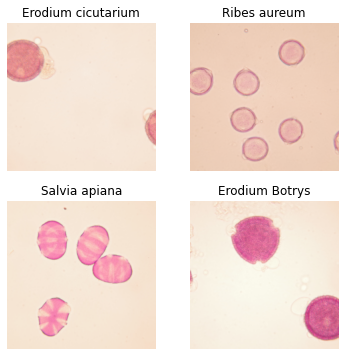

In [37]:
data.show_batch(max_n=9)

# Training the model

In [38]:
learn = Learner(data, xresnet34(n_out=numClasses), metrics=[accuracy])
# Model starts frozen by default (prevents well-trained weights from being modified)
# Instead we modify the later fully-connected features to fit our specific data!

In [39]:
# Trains 2 epochs while frozen, where only fully-connected weights change
# Learns at the default rate
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,2.871037,3.209969,0.197917,01:07
1,2.462931,2.364781,0.281250,01:06


In [40]:
# Save the model
learn.save("Model-Head")

Path('models/Model-Head.pth')

In [42]:
# Reload the model & unfreeze it
learn.load("Model-Head")
learn.unfreeze()

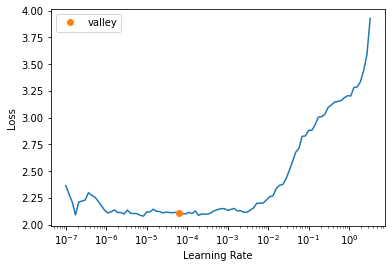

In [43]:
# Find initial learning rate (unfrozen)
valley = learn.lr_find()

In [44]:
# Train for 20 epochs with found lr
learn.fit_one_cycle(20, valley)

epoch,train_loss,valid_loss,accuracy,time
0,2.240830,2.208096,0.281250,01:08
1,2.233951,2.182793,0.302083,01:07
2,2.174820,2.109805,0.312500,01:06
3,2.090692,2.016453,0.364583,01:07
4,2.113793,2.096856,0.395833,01:07
5,1.957542,1.913075,0.364583,01:08
6,1.871483,1.697671,0.479167,01:10
7,1.817852,1.587796,0.489583,01:07
8,1.725608,1.563112,0.500000,01:09
9,1.667972,1.525207,0.520833,01:05


In [45]:
# Save the model
learn.save("Model-Final")

Path('models/Model-Final.pth')

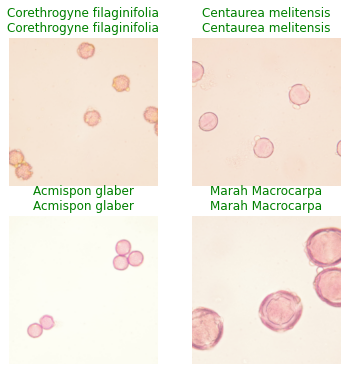

In [46]:
learn.show_results(max_n=9)

# Interpreting the model

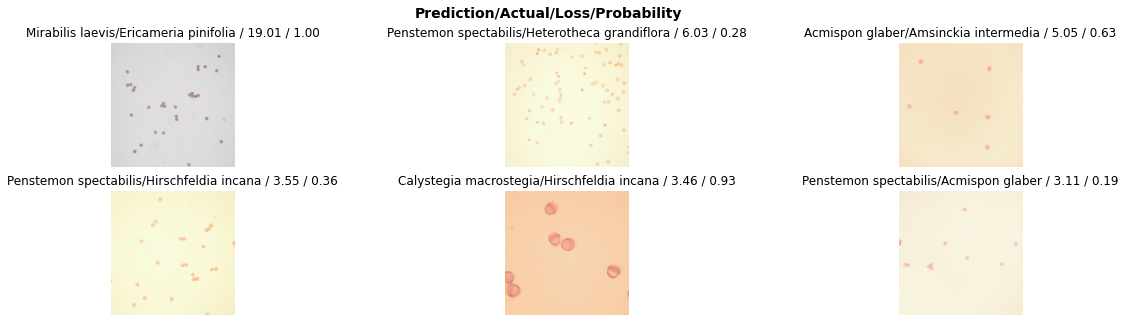

In [51]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(6, figsize=(20,5))

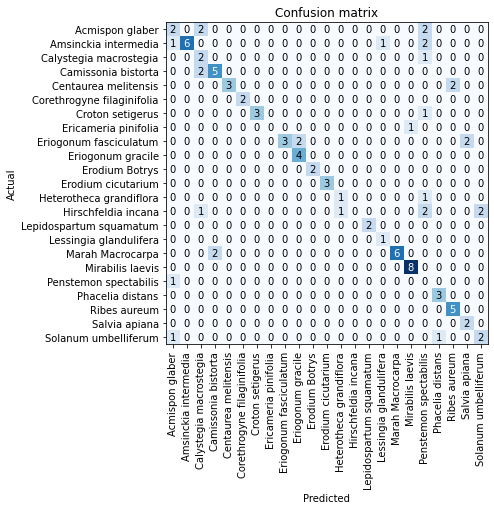

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,7))

In [49]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused()
# Shows (Actual, Predicted, Occurances)

[('Acmispon glaber', 'Calystegia macrostegia', 2),
 ('Acmispon glaber', 'Penstemon spectabilis', 2),
 ('Amsinckia intermedia', 'Penstemon spectabilis', 2),
 ('Camissonia bistorta', 'Calystegia macrostegia', 2),
 ('Centaurea melitensis', 'Ribes aureum', 2),
 ('Eriogonum fasciculatum', 'Eriogonum gracile', 2),
 ('Eriogonum fasciculatum', 'Salvia apiana', 2),
 ('Hirschfeldia incana', 'Penstemon spectabilis', 2),
 ('Hirschfeldia incana', 'Solanum umbelliferum', 2),
 ('Marah Macrocarpa', 'Camissonia bistorta', 2),
 ('Amsinckia intermedia', 'Acmispon glaber', 1),
 ('Amsinckia intermedia', 'Lessingia glandulifera', 1),
 ('Calystegia macrostegia', 'Penstemon spectabilis', 1),
 ('Croton setigerus', 'Penstemon spectabilis', 1),
 ('Ericameria pinifolia', 'Mirabilis laevis', 1),
 ('Heterotheca grandiflora', 'Penstemon spectabilis', 1),
 ('Hirschfeldia incana', 'Calystegia macrostegia', 1),
 ('Hirschfeldia incana', 'Heterotheca grandiflora', 1),
 ('Penstemon spectabilis', 'Acmispon glaber', 1),
 ('